In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time
np.random.seed(42)

In [25]:
def load_cls(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [26]:
path = "/scratch/pbanerj6/sml-dataset/"
trainSamples = 75000
n_iter = 1000
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [27]:
X_train = load_cls(path+"X_train_tokens.p")[:trainSamples]
X_val_cls = load_cls(path+"X_val_tokens.p")

In [28]:
print(len(X_train))

75000


In [29]:
y_train = load_cls(path+"y_train.p")[:trainSamples]
y_val = load_cls(path+"y_val.p")

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

def my_preprocessor(doc):
    return doc

# tokenize the doc and lemmatize its tokens
def my_tokenizer(doc):
    return doc

custom_vec = CountVectorizer(preprocessor=my_preprocessor, tokenizer=my_tokenizer)
cwm = custom_vec.fit_transform(X_train)
tokens = custom_vec.get_feature_names()

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import svm

In [32]:
feature_pipeline = Pipeline([
('vect',  CountVectorizer(min_df=.0025, max_df=0.25, ngram_range=(1,3),preprocessor=my_preprocessor, tokenizer=my_tokenizer)),
('tfidf', TfidfTransformer()),
])

In [33]:
X_train_f = feature_pipeline.fit_transform(X_train)
X_val_f =feature_pipeline.transform(X_val_cls)

In [34]:
from sklearn.model_selection import GridSearchCV
parameters = {
     'C': [0.001, 0.01, 0.1, 1,10],
     'gamma': [0.001, 0.01, 0.1, 1]
 }

In [35]:
gs_clf = GridSearchCV(svm.SVC(verbose=True,probability=True,cache_size=7000,max_iter=n_iter,gamma='auto',kernel='rbf'), 
                      parameters, cv=5, iid=True, n_jobs=-1, verbose=4)

In [36]:
model = gs_clf.fit(X_train_f, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed: 34.4min
[Parallel(n_jobs=-1)]: Done  87 out of 100 | elapsed: 56.4min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 57.3min finished


[LibSVM]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [37]:
model.best_score_

0.5610266666666667

In [38]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'C': 0.1, 'gamma': 0.01}
C: 0.1
gamma: 0.01


In [39]:
pickle.dump(model,open("SVM_RBF_"+str(trainSamples)+"_"+str(n_iter)+".pkl",'wb'))

In [40]:
X_test = load_cls(path+"X_test_tokens.p")
y_test = load_cls(path+"y_test.p")

In [45]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [46]:
from sklearn.metrics import accuracy_score

In [47]:
valAccuracy = []
testAccuracy = []
mrrScore = []
precisionAt1 = []
precisionAt3 = []

# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel = svm.SVC(verbose=True,
                        probability=True,
                        cache_size=7000,
                        max_iter=n_iter,
                        gamma=model.best_params_['gamma'],
                        kernel='rbf',
                        C=model.best_params_['C'])

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    X_train_f = feature_pipeline.fit_transform(X_train[:eachTrain])
    bestModel.fit(X_train_f,y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    X_val_f = feature_pipeline.transform(X_val_cls)
    preds_val = bestModel.predict(X_val_f)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    X_test_f = feature_pipeline.transform(X_test)
    preds_test = bestModel.predict(X_test_f)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_f)
    qid2c,qid2indexmap = load_ranking("test")
    print (mrrwrapper(qid2c,qid2indexmap,preds_test_probs))
    mrr, pAt1, pAt3 = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    precisionAt1.append(pAt1)
    precisionAt3.append(pAt3)
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)
print (precisionAt1)
print (precisionAt3)

SampleSize: 100
[LibSVM]Train Time:0.07 sec
Validation Accuracy: 49.85%
Validation Time:2.27 sec
Test Accuracy: 49.97%
Test Time:2.26 sec
(0.38564030784030773, 0.136, 0.47333333333333333)
MRR: 0.38564030784030773
MRR Time:1.03 sec
SampleSize: 500
[LibSVM]Train Time:1.06 sec
Validation Accuracy: 50.28%
Validation Time:4.88 sec
Test Accuracy: 50.15%
Test Time:4.90 sec
(0.3722387205387203, 0.12466666666666666, 0.4513333333333333)
MRR: 0.3722387205387203
MRR Time:3.65 sec
SampleSize: 1000
[LibSVM]Train Time:4.04 sec
Validation Accuracy: 52.90%
Validation Time:8.40 sec
Test Accuracy: 52.73%
Test Time:8.43 sec
(0.2856666666666618, 0.0, 0.0)
MRR: 0.2856666666666618
MRR Time:7.15 sec
SampleSize: 10000
[LibSVM]Train Time:56.79 sec
Validation Accuracy: 55.52%
Validation Time:12.92 sec
Test Accuracy: 54.88%
Test Time:12.80 sec
(0.4636460317460324, 0.222, 0.604)
MRR: 0.4636460317460324
MRR Time:11.48 sec
SampleSize: 20000
[LibSVM]Train Time:116.15 sec
Validation Accuracy: 54.85%
Validation Time:12

In [48]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SVM_Tokens_RBF_Accuracy.png")
    #plt.show()

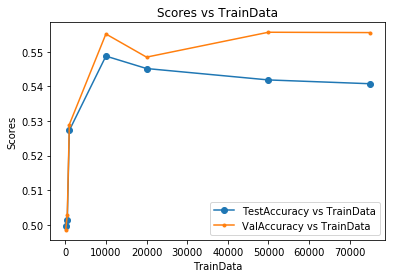

In [49]:
accuracyVisualization()

In [50]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SVM_Tokens_RBF_Mrr.png")
    plt.show()

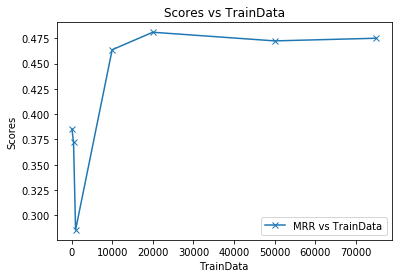

In [51]:
mrrVisualization()